In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('archive/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

archive/sat-6-full.mat
archive/sat6annotations.csv
archive/X_test_sat6.csv
archive/X_train_sat6.csv
archive/y_test_sat6.csv
archive/y_train_sat6.csv


In [2]:
import csv
import pandas as pd
import numpy as np
from numpy.random import randint, random, normal
import matplotlib.pyplot as plt

In [3]:
import os
import numpy as np
import pandas as pd
import scipy.io
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
np.random.seed(1)

In [4]:
#filenames
label_table = pd.read_csv(dirname+ '/' +'sat6annotations.csv', header=None)
label_table

,0,1,2,3,4,5,6
0,building,1,0,0,0,0,0
1,barren_land,0,1,0,0,0,0
2,trees,0,0,1,0,0,0
3,grassland,0,0,0,1,0,0
4,road,0,0,0,0,1,0
5,water,0,0,0,0,0,1


In [5]:
EPOCHS = 10
BATCH_SIZE = 64
IMG_SHAPE = 28, 28, 4

TRAIN_NUM, TEST_NUM = 324000, 81000  # from the dataset site
train_steps, test_steps = TRAIN_NUM // BATCH_SIZE, TEST_NUM // BATCH_SIZE

In [6]:
def get_gen(x_csv_path, y_csv_path, batch_size=BATCH_SIZE,
            img_shape=IMG_SHAPE, labels_num=6, augment=False):
  """
  Return a generator.
  
  This function returns a data generator. Every time the generator is called
  it yields one batch of pairs (images, labels).
  """
  xf, yf = open(x_csv_path), open(y_csv_path)
  x_reader, y_reader = csv.reader(xf, delimiter=","), csv.reader(yf, delimiter=",")

  while True:
    imgs = np.zeros((batch_size, *img_shape))
    labels = np.zeros((batch_size, labels_num))

    for i in range(batch_size):

      try:
        x_line, y_line = next(x_reader), next(y_reader)
      except:
        # this except clause resets the line readers when they reach the end of the files
        xf.close()
        yf.close()
        xf, yf = open(x_csv_path), open(y_csv_path)
        x_reader, y_reader = csv.reader(xf, delimiter=","), csv.reader(yf, delimiter=",")
        x_line, y_line = next(x_reader), next(y_reader)

      img = np.reshape(list(map(int, x_line)), img_shape)
      img = preprocess_img(img, augment)
      imgs[i] = img

      label = np.array(list(map(int, y_line)))
      labels[i] = label

    yield imgs, labels


def preprocess_img(img, augment=False):
  """
  Preprocess the images.
  
  Takes as input an image and a boolean value (augment).
  The standard preprocess includes only division by 255.0 (which maps from [0, 255] to [0.0, 1.0]).
  """
  img = img / 255.0
  if augment:
    img = augment_img(img)
  
  return img


def augment_img(img):
  """
  Augment an image.
  
  Image augmentation is useful in order to avoid overfitting.
  This function adds random (normal) noise and randomly flip and/or rotate each image.
  """
  # add noise
  gauss = normal(0, 0.05, img.shape)
  img = img + gauss
  img = np.clip(img, 0, 1)

  # rotate 0/90/180/270
  img = np.rot90(img, randint(0, 3), axes=(0, 1))

  # flip/no-flip orizontaly/vertical
  if random() < 0.5: img = img[:, ::-1, :]
  if random() < 0.5: img = img[::-1, :, :]

  return img


def plot_images(images, labels=None, preds=None):
  """
  Plot a batch of images and labels.
  
  This function plots a sample of images from the dataset along with their labels as image header.
  If preds is given the header is real label/predicted label.
  """
  c = 8
  labels = np.argmax(labels, -1) if labels is not None else labels
  r = int(len(images) / c)
  if preds is not None: preds = np.argmax(preds, -1)
  fig, axs = plt.subplots(r, c, figsize=(16, 16))
  cnt = 0
  for i in range(r):
    for j in range(c):
      axs[i, j].imshow(images[cnt, ..., :3], cmap='gray')
      axs[i, j].axis('off')
      if labels is not None:
        title = label_names[labels[cnt]] if preds is None else '%s/%s' % (label_names[labels[cnt]],
                                                                        label_names[preds[cnt]])
        axs[i, j].set_title(title, fontsize=12 if preds is None else 8)
      cnt += 1
  plt.show()

In [8]:
train_gen = get_gen('X_train_sat6.csv', 'y_train_sat6.csv', augment=True)
test_gen = get_gen('X_test_sat6.csv', 'y_test_sat6.csv')

label_names = list(pd.read_csv('archive/sat6annotations.csv', header=None)[0])
print('label names:\n%s' % ', '.join(label_names))

label names:
building, barren_land, trees, grassland, road, water


In [9]:
classes = ['building', 'barren_land','trees', 'grassland', 'road', 'water']
training_labels = pd.read_csv(dirname+ '/' + 'y_train_sat6.csv', header=None)
training_labels.columns = classes
training_labels[:5]

,building,barren_land,trees,grassland,road,water
0,0,0,1,0,0,0
1,0,1,0,0,0,0
2,0,0,0,0,0,1
3,0,0,0,0,0,1
4,0,0,0,0,0,1


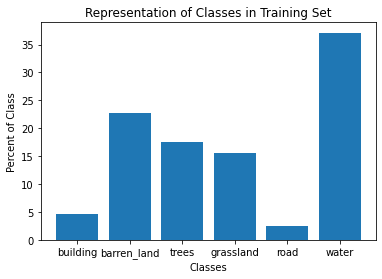

In [10]:
perc_of_class_train = {x: round(training_labels[x].sum()/324000, 3) * 100 for (i, x) in enumerate(classes)}
plt.bar(range(len(perc_of_class_train)), list(perc_of_class_train.values()), align='center')
plt.xticks(range(len(perc_of_class_train)), list(perc_of_class_train.keys()))
plt.ylabel('Percent of Class')
plt.xlabel('Classes')
plt.title('Representation of Classes in Training Set')
plt.show()

In [11]:
perc_of_class_train

{'building': 4.6,
 'barren_land': 22.7,
 'trees': 17.5,
 'grassland': 15.5,
 'road': 2.5,
 'water': 37.1}

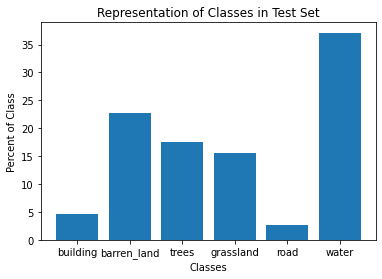

In [12]:
test_labels = pd.read_csv(dirname+ '/' +'y_test_sat6.csv', header=None)
test_labels.columns = classes
perc_of_class_test = {x: round(test_labels[x].sum()/81000, 3) * 100 for (i, x) in enumerate(classes)}
plt.bar(range(len(perc_of_class_test)), list(perc_of_class_test.values()), align='center')
plt.xticks(range(len(perc_of_class_test)), list(perc_of_class_test.keys()))
plt.ylabel('Percent of Class')
plt.xlabel('Classes')
plt.title('Representation of Classes in Test Set')
plt.show()

In [13]:
perc_of_class_test

{'building': 4.6,
 'barren_land': 22.7,
 'trees': 17.5,
 'grassland': 15.6,
 'road': 2.6,
 'water': 37.1}

In [14]:
X_train = pd.read_csv(dirname+ '/''X_train_sat6.csv', header=None, nrows=300)

In [15]:
def row_to_img(row_values, ir=False):
    if ir:
        return row_values.reshape(-1, 28, 28, 4).clip(0, 255).astype(np.uint8).squeeze(axis=0)[:,:,-1]
    else:
        return row_values.reshape(-1, 28, 28, 4).clip(0, 255).astype(np.uint8).squeeze(axis=0)[:,:,:3]

In [16]:
def get_labels(row_values):
    annotations = ['building', 'barren_land','trees', 'grassland', 'road', 'water']
    labels = [annotations[i] for i, x in enumerate(row_values) if x == 1]
    return labels[0]

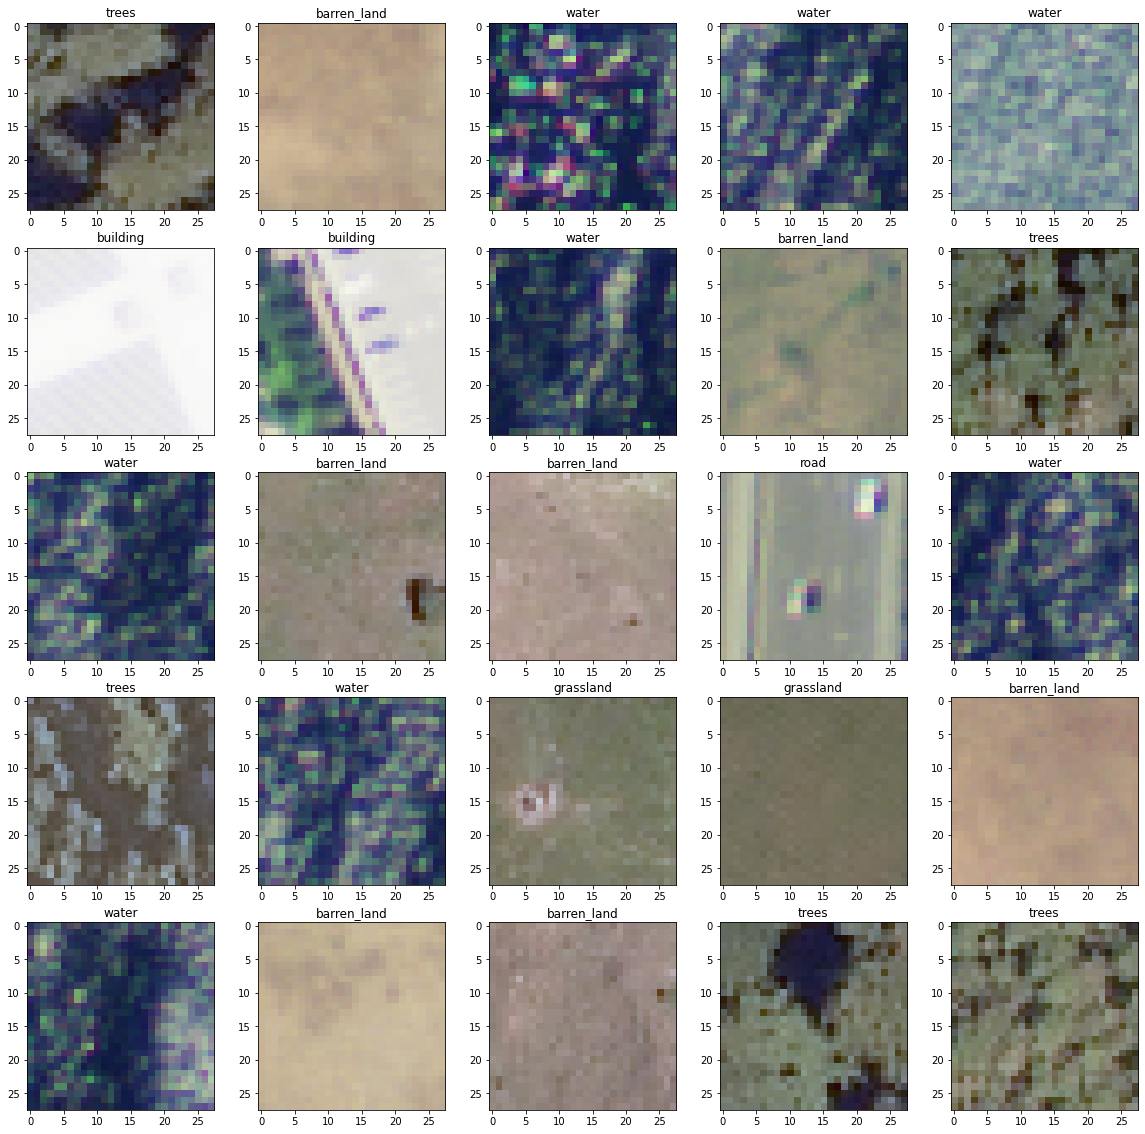

In [17]:
fig, axs = plt.subplots(5, 5, figsize = (20, 20))
for i, ax in enumerate(axs.flatten()):
    ax.set_title(get_labels(training_labels.iloc[i].values))
    ax.imshow(row_to_img(X_train.iloc[i].values))

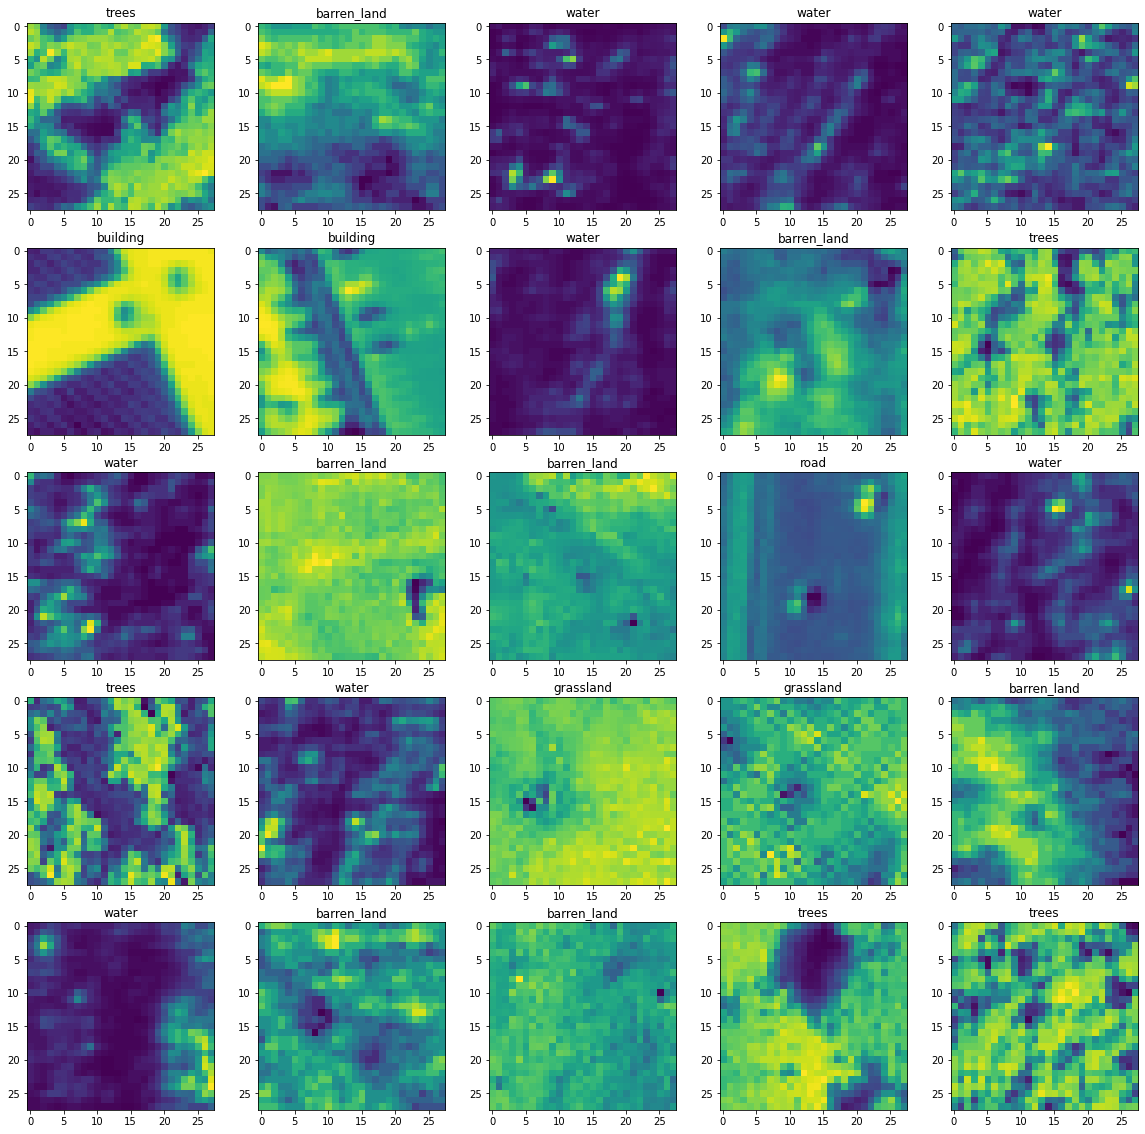

In [18]:
fig, axs = plt.subplots(5, 5, figsize = (20, 20))
for i, ax in enumerate(axs.flatten()):
    ax.set_title(get_labels(training_labels.iloc[i].values))
    ax.imshow(row_to_img(X_train.iloc[i].values, ir=True))

In [19]:
sample = X_train.copy()
sample['labels'] = [get_labels(x.values) for i, x in training_labels[:300].iterrows()]

In [20]:
pca = PCA(n_components=2)
components = pd.DataFrame(pca.fit_transform(sample.drop('labels', axis=1)), columns=['component_1', 'component_2'])
components['labels'] = sample['labels']

In [21]:
components.head()

,component_1,component_2,labels
0,-937.353162,1195.035981,trees
1,3173.150592,-282.175904,barren_land
2,-3104.479505,-503.230050,water
3,-3090.313396,-589.897575,water
4,-652.327617,-2494.766648,water


In [22]:
subsets = [components.loc[components['labels'] == x] for x in classes]

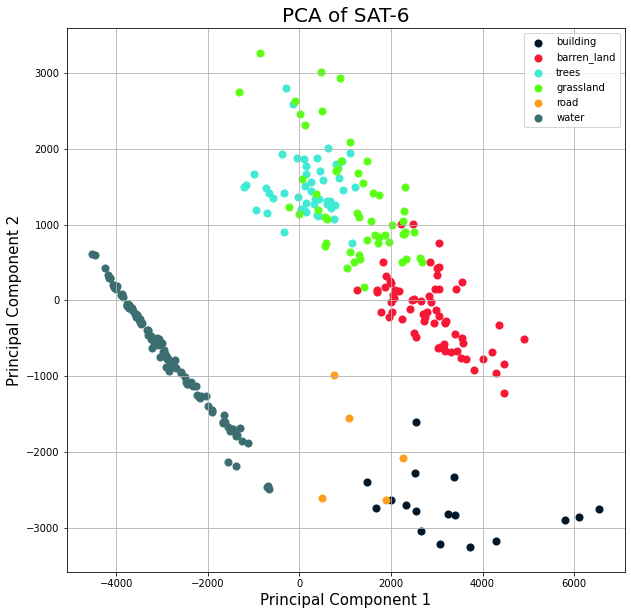

In [23]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA of SAT-6', fontsize = 20)

color_map = {'building': '#011627', 'barren_land': '#F71735', 'trees': '#41EAD4', 'grassland': '#5AFF15', 'road': '#FF9F1C', 'water': '#3C6E71'}

for subset in subsets:
    label = subset['labels'].values.tolist()[0]
    ax.scatter(x=subset['component_1'], y=subset['component_2'], s=50, c=color_map[label])

ax.legend(color_map.keys())
ax.grid()
plt.show()

In [24]:
pca.explained_variance_ratio_.cumsum()

array([0.66852571, 0.83619745])

We note that the 2 principal components constitute together only achieve an explained variance ratio of 83%.

In [25]:
pca_95 = PCA(n_components=0.95, svd_solver='full')
components_95 = pca_95.fit_transform(sample.drop('labels', axis=1))
components_95.shape

(300, 51)

We would need to include at least 51 components to achieve an explained variance ratio of 95%.

In [26]:
tsne = TSNE(n_components=2, perplexity=32)
components = pd.DataFrame(tsne.fit_transform(sample.drop('labels', axis=1)), columns=['component_1', 'component_2'])
components['labels'] = sample['labels']
components.head()

,component_1,component_2,labels
0,2.413198,21.626570,trees
1,-8.957438,8.351441,barren_land
2,10.412830,-24.164276,water
3,8.806357,-21.082308,water
4,5.367911,-14.891006,water


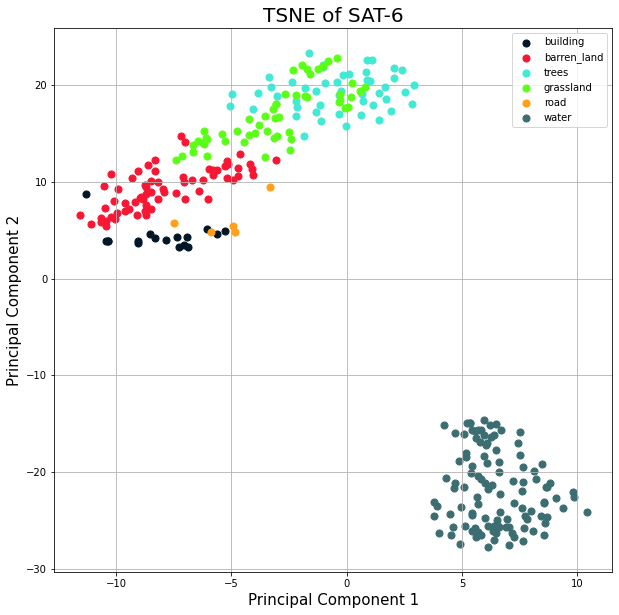

In [27]:
subsets = [components.loc[components['labels'] == x] for x in classes]
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('TSNE of SAT-6', fontsize = 20)

color_map = {'building': '#011627', 'barren_land': '#F71735', 'trees': '#41EAD4', 'grassland': '#5AFF15', 'road': '#FF9F1C', 'water': '#3C6E71'}

for subset in subsets:
    label = subset['labels'].values.tolist()[0]
    ax.scatter(x=subset['component_1'], y=subset['component_2'], s=50, c=color_map[label])

ax.legend(color_map.keys())
ax.grid()
plt.show()

The TSNE plot shows a similar relationship to the PCA except that the two clusters of the 5 classes excluding `water` are located much more closely together.

Baseline
---
Before training deep neural networks training on hundres of thousands of images, lets attempt to train at least a weak classifier on the subsample of data. Anything classifier that is 16% accurate or more is better than random.

For our baseline, we will use the a random forest classifier trained on 51 principal components.

In [28]:
clf = RandomForestClassifier(verbose=True)
X = components_95
y = sample['labels']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [29]:
clf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


RandomForestClassifier(verbose=True)

In [30]:
clf.score(X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


0.8933333333333333

In [31]:
y_pred = clf.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

 barren_land       1.00      0.86      0.92        21
    building       0.67      1.00      0.80         4
   grassland       0.91      0.83      0.87        12
        road       0.00      0.00      0.00         0
       trees       0.80      0.73      0.76        11
       water       1.00      1.00      1.00        27

    accuracy                           0.89        75
   macro avg       0.73      0.74      0.73        75
weighted avg       0.94      0.89      0.91        75



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
c:\users\atharva patil\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Our classifier recieved an overall accuracy score of 90.6%~ 91%. We see from the classification report that the model failed to correctly identify any `road` chips. It also struggled with `grassland`, `building`, and `trees` chips. We will attempt to correct these errors with a more robust classifier.